In [ ]:
# set jax backend cpu
import jax
jax.config.update("jax_platform_name", "cpu")

import os, sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))
from crazymarl.experiments.experiment_loader import Experiment


import asdf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set_theme(style="white", palette="muted", font_scale=0.8)

import mpl_fontkit as fk
fk.install("Inter")         # downloads Inter from Google Fonts
fk.set_font("Inter") 
# Set the default font size for all plots
plt.rcParams['font.size'] = 10

textwidth = 6.32283  # inches from 455,24411 pt textwidth in the document
# set default figure width to textwidth
plt.rcParams['figure.figsize'] = (textwidth, textwidth * 0.618)  # golden ratio
plt.rcParams['figure.dpi'] = 300  # high-quality output

color_array = sns.color_palette("muted", 10)






single_eight = Experiment('../../../experiments_data/2_quads_figure_eight_20250625_221215/2_quads_figure_eight.crazy.asdf')
exp.info()

Font name: `Inter`
Metal device set to: Apple M4 Pro

systemMemory: 48.00 GB
maxCacheSize: 18.00 GB

Experiment loaded from ../../../experiments_data/2_quads_figure_eight_20250625_221215/2_quads_figure_eight.crazy.asdf with 2 quads
File: ../../../experiments_data/2_quads_figure_eight_20250625_221215/2_quads_figure_eight.crazy.asdf
Quads: 2
Timesteps: 5000
Runs: 100
DT: 0.004
Duration: 19.996s
First done per run: [4378 2101 2400 2268 4999  399 1321 1241 2205 2117 4999 2289 4999 2309
 4804 4999 4999 3836 4999 4999 2275 4999 1247 4999 3489 3025 3321 1856
 2364 1131 4412 4999 2510 1537  418 4999 2448 2632 2328 2414 4999 4999
 4999 4999 4999   67 2259 4999 2323 4999 2713 2098 4999 4999 1724 2428
 2248  820 2812 2421 2259  447 4999 2279 4538 4999 1115 2267   65 1129
 4999 4999 4999 2343 2470 3684 3528 4326 1450 3309 2688  101 2548 4999
 4999 2277 2428 3375 4999 4705 2285 4999 2421 4999 4999  119 4999  917
 1068 1255]
Full runs (>2000): 98/100
 trajectory: (5000, 3)
Sample feature shapes:
 pa

W0000 00:00:1750885234.436606 41814255 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1750885234.455871 41814255 service.cc:145] XLA service 0x317eba770 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750885234.455880 41814255 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1750885234.456916 41814255 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1750885234.456926 41814255 mps_client.cc:384] XLA backend will use up to 38654230528 bytes on device 0 for SimpleAllocator.


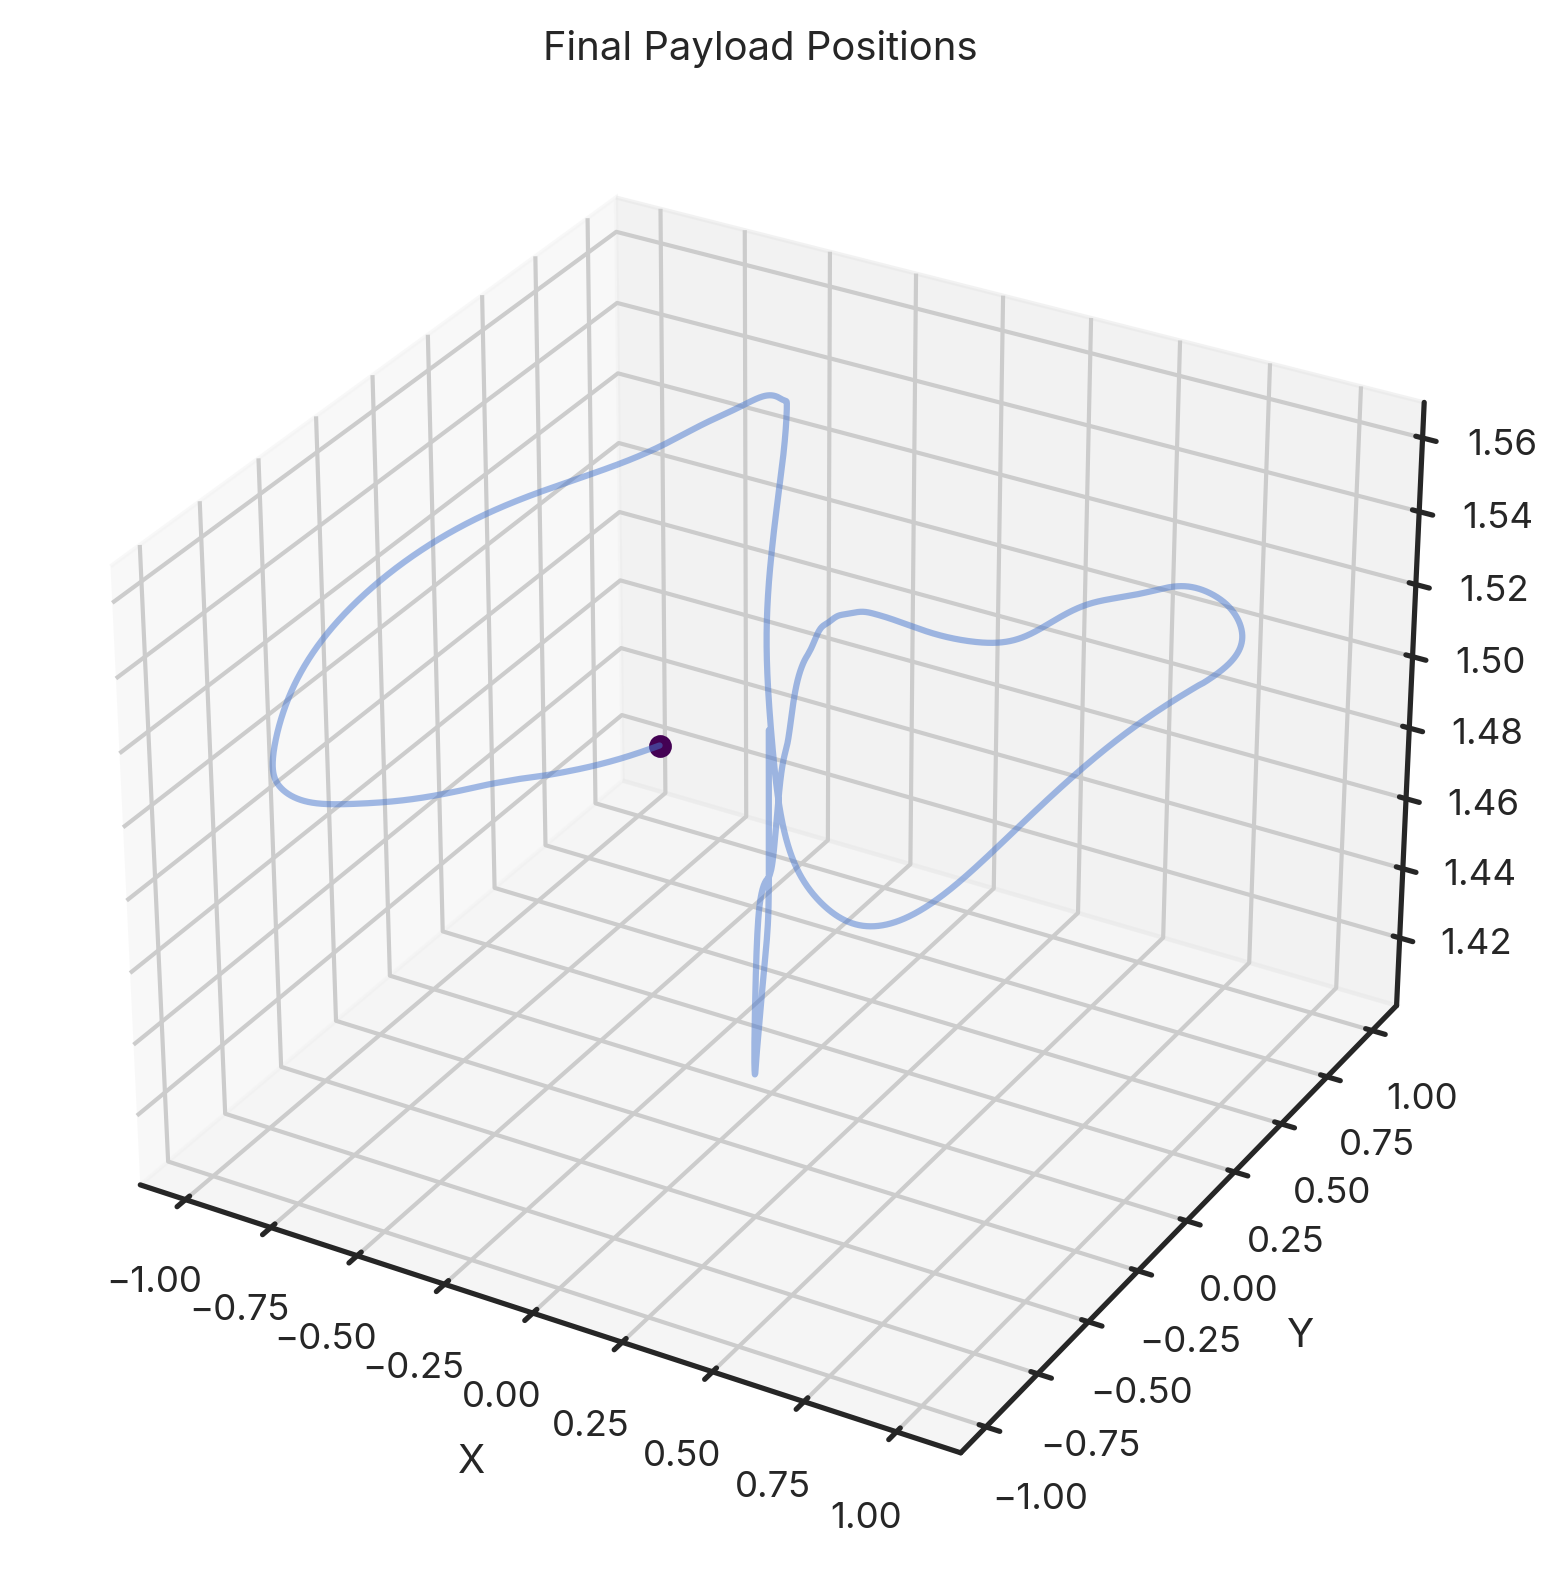

In [2]:
def plot_3d_final_positions(exp: Experiment, runs=None, agent: int = 0, width: float = textwidth):
    """
    Scatter the **final** payload position in 3D for the selected runs.
    runs: int, list of ints, or slice (default -> [0])
    """
    # build a full list of run‐indices
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.array([0])
    else:
        run_idxs = all_runs[runs]

    fig = plt.figure(figsize=(width, width))
    ax = fig.add_subplot(111, projection='3d')

    # payload_pos: (T, runs, 3)
    final = exp.payload_pos[-1, run_idxs, :]       # (len(run_idxs), 3)
    xs, ys, zs = final[:, 0], final[:, 1], final[:, 2]
    ax.scatter(xs, ys, zs, c=np.arange(len(run_idxs)), cmap='viridis', depthshade=True)

    # plot full trajectories for those runs that both completed and were selected
    completed = np.intersect1d(exp.full_runs, run_idxs)
    for idx in completed:
        path = exp.payload_pos[:, idx, :]         # (T, 3)
        ax.plot(path[:, 0], path[:, 1], path[:, 2], alpha=0.5)

    ax.set(xlabel='X', ylabel='Y', zlabel='Z', title='Final Payload Positions')
    return fig
plot_3d_final_positions(exp);

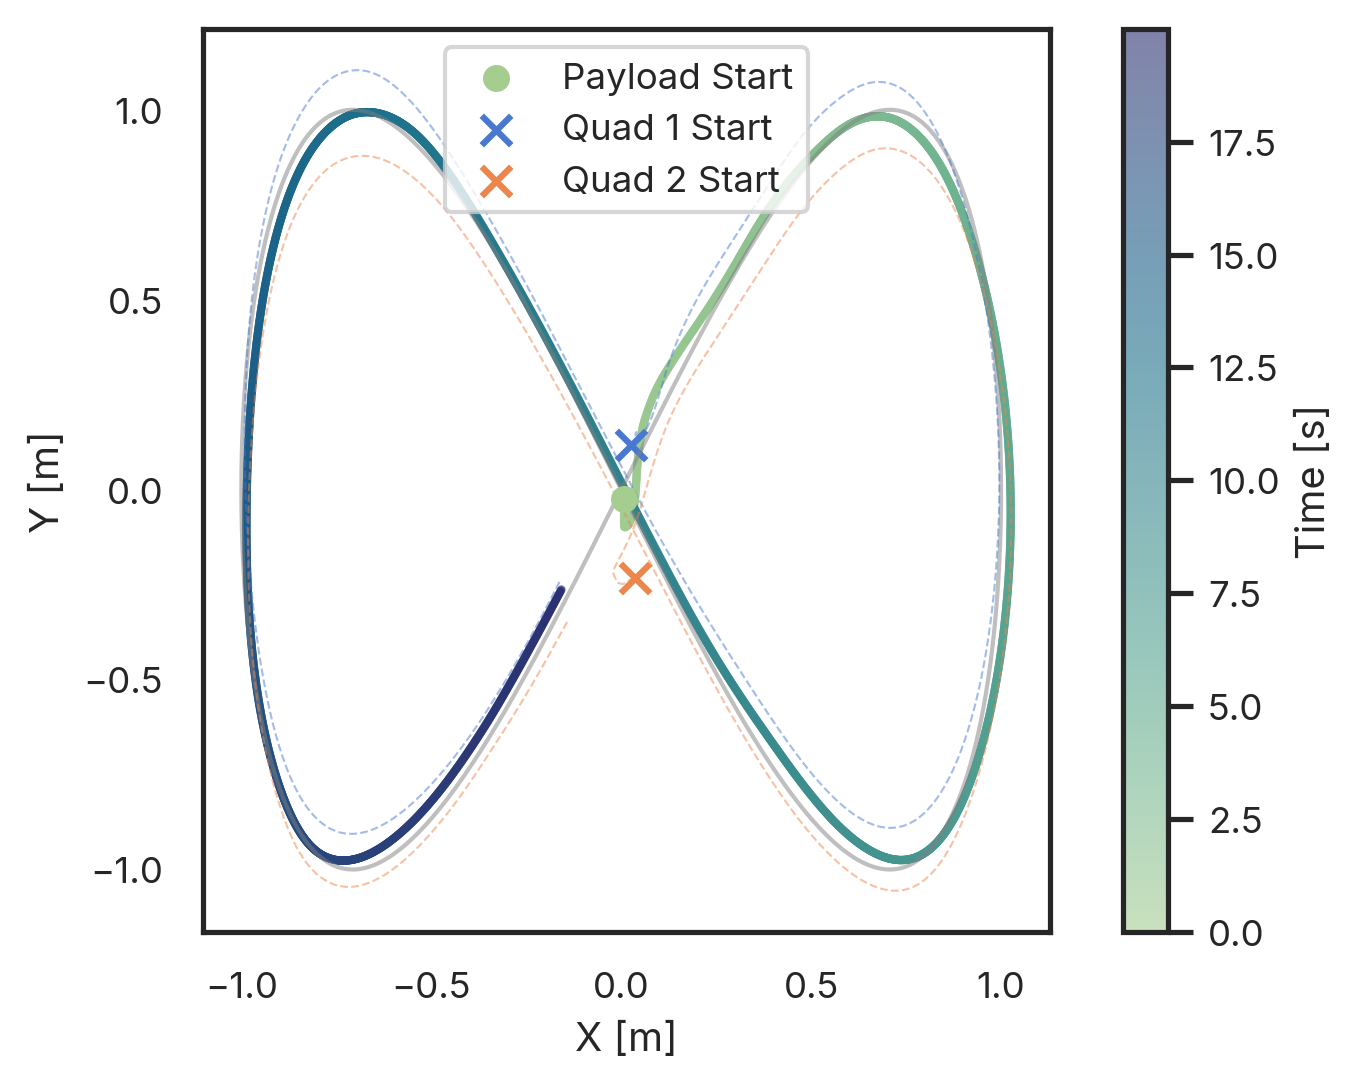

In [3]:

def plot_xy_plane(exp: Experiment, runs=None, width: float = textwidth):
    """
    Plot payload vs. target in the XY plane.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.array([0])
    else:
        run_idxs = all_runs[runs]

    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    # global trajectory: (T, 3)
    traj = exp.trajectory
    ax.plot(traj[:, 0], traj[:, 1], color='gray', alpha=0.5, linewidth=1)

    # scatter each selected-and-completed run
    completed = np.intersect1d(exp.full_runs, run_idxs)
    for idx in completed:
        rel = exp.payload_pos[:, idx, :]   # (T, 3)
        sc = ax.scatter(rel[:, 0], rel[:, 1], c=exp.time, cmap='crest', s=1, alpha=0.6)

    # get crest first color
    cmap = plt.get_cmap('crest')

    # mark start
    if completed.size:
        start = exp.payload_pos[0, completed[0], :]
        ax.scatter(start[0], start[1], s=30, label='Payload Start', marker='o', color=cmap(0.0), zorder=5)
        # also show initial quad positions
        q0 = start + exp.own_rel_pos[0, completed[0], 0, :]
        others0 = exp.other_rel_pos[0, completed[0], 0, :3]
        
        # plot the quad paths
        q_paths = exp.payload_pos[:, completed[0], :2][:, None, :] \
                  + exp.own_rel_pos[:, completed[0], :, :2]  # (T, Q, 2)
        for q in range(q_paths.shape[1]):
            ax.plot(q_paths[:, q, 0], q_paths[:, q, 1], alpha=0.5, linewidth=0.5, linestyle='--', color =color_array[q])
            ax.scatter(q_paths[0, q, 0], q_paths[0, q, 1], s=50, marker='x',color =color_array[q], label=f'Quad {q+1} Start')


    
    #legend
    ax.legend(loc='best')
    ax.set_aspect('equal', 'box')
    fig.colorbar(sc, ax=ax, label='Time [s]')
    ax.set(xlabel='X [m]', ylabel='Y [m]')
    return fig

plot_xy_plane(exp);

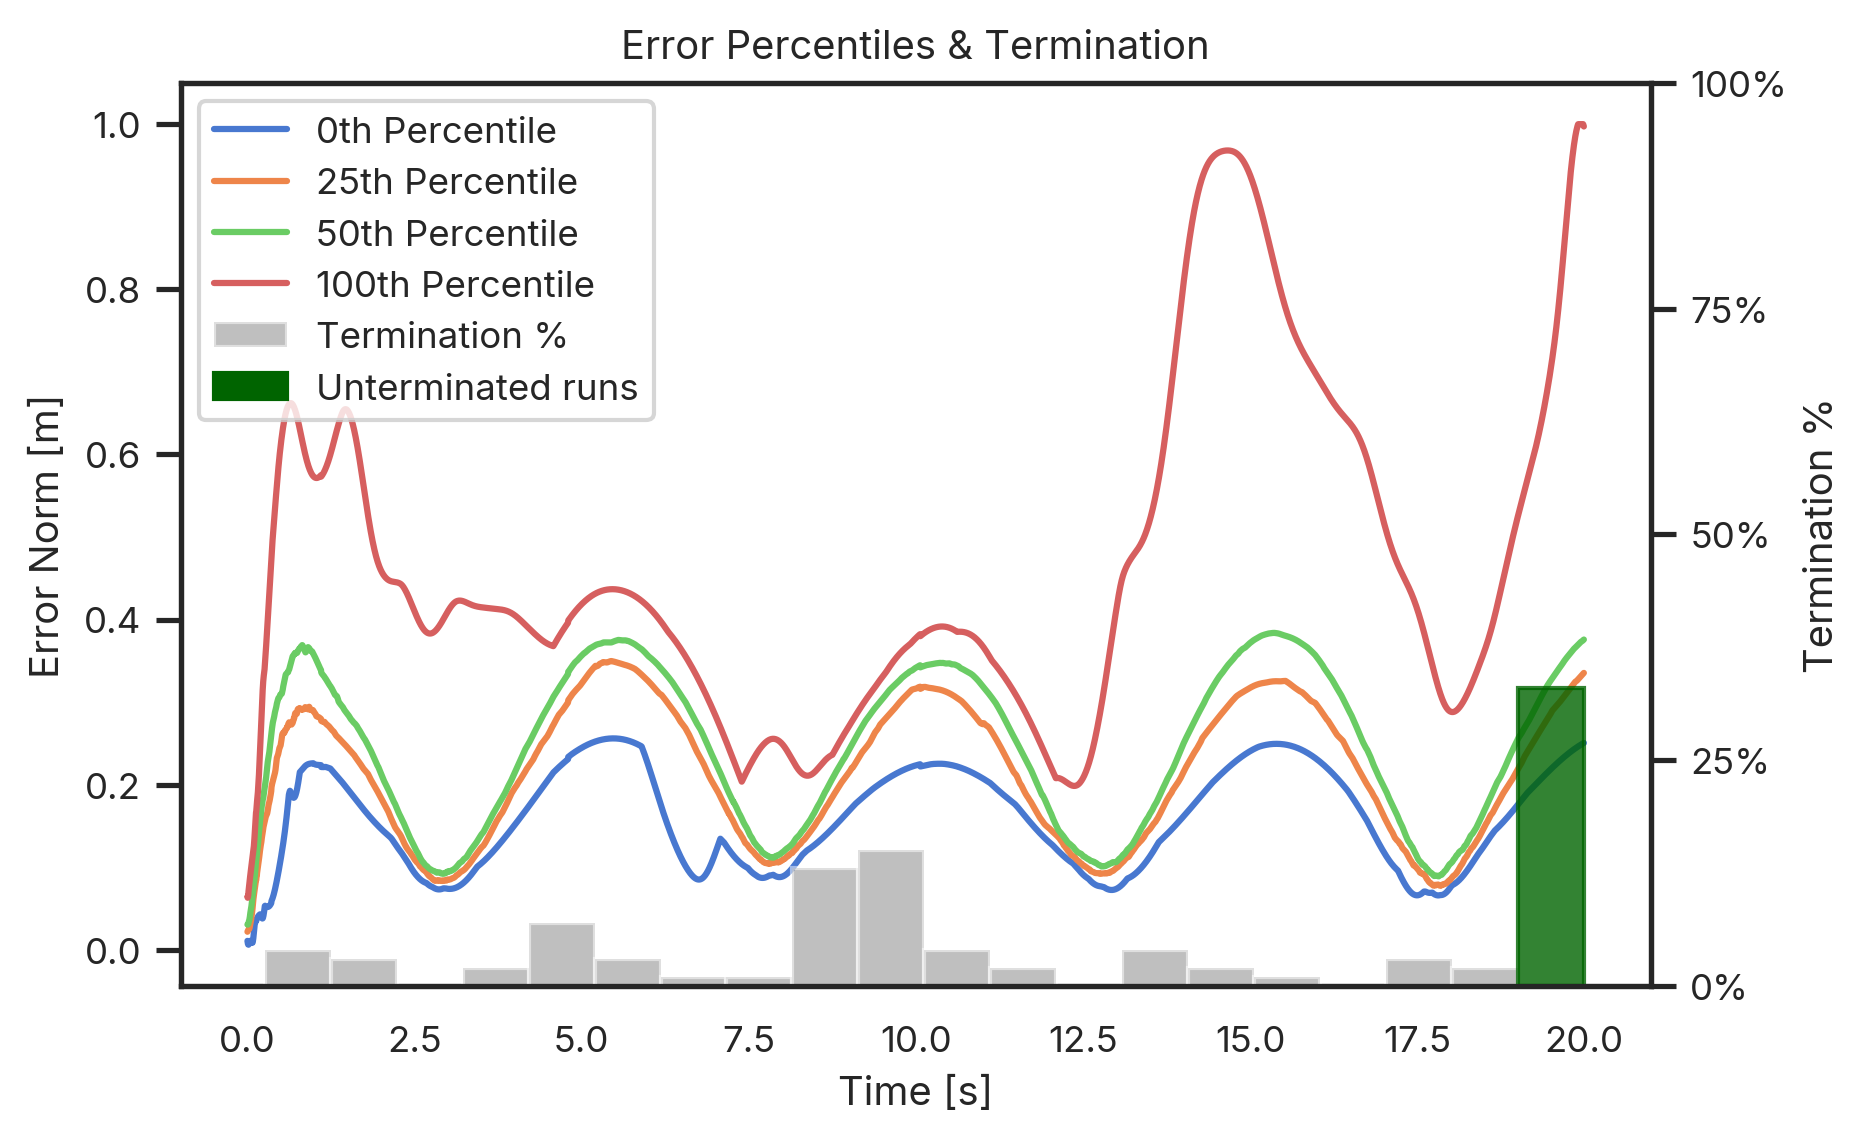

In [13]:
import matplotlib.patches as mpatches
def plot_error_percentiles(exp: Experiment, runs=None, width: float = textwidth):
    """
    Show error-norm percentiles and a histogram of termination times (as %),
    and highlight the last bin as “Unterminated runs”.
    """
    # --- select runs and compute norms ---
    all_runs = np.arange(exp.obs.shape[1])
    run_idxs = all_runs if runs is None else all_runs[runs]

    max_t = exp.payload_error.shape[0]
    norms = np.linalg.norm(exp.payload_error[:max_t, run_idxs, 0, :], axis=-1)

    # --- set up figure & primary axis (percentiles) ---
    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    for p in [0, 25, 50, 100]:
        ax.plot(
            exp.time[:max_t],
            np.percentile(norms, p, axis=1),
            label=f'{p}th Percentile',
        )
    ax.set(
        xlabel='Time [s]',
        ylabel='Error Norm [m]',
        title='Error Percentiles & Termination'
    )

    # --- compute termination histogram as percentages ---
    hist, bins = np.histogram(exp.first_dones[run_idxs] * exp.dt, bins=20)
    freq_pct = hist / hist.sum() * 100  # convert to percent

    # --- plot bars on the secondary axis ---
    ax2 = ax.twinx()
    bars = ax2.bar(
        bins[:-1],
        freq_pct,
        width=np.diff(bins),
        alpha=0.5,
        color='gray',
        align='edge',
        label='Termination %'
    )
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('Termination %')
    pct_ticks = np.linspace(0, 100, 5)
    ax2.set_yticks(pct_ticks)
    ax2.set_yticklabels([f'{int(t)}%' for t in pct_ticks])

    # --- highlight the last bar as "Unterminated runs" ---
    last_bar = bars[-1]
    last_bar.set_color('darkgreen')
    last_bar.set_alpha(0.8)

    # --- combine legends from both axes + highlight patch ---
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    highlight_patch = mpatches.Patch(color='darkgreen', label='Unterminated runs')
    ax.legend(
        handles=h1 + h2 + [highlight_patch],
        labels=l1 + l2 + ['Unterminated runs'],
        loc='upper left'
    )

    return fig

plot_error_percentiles(exp);

In [5]:

def plot_xy_plane(exp: Experiment, runs=None, width: float = textwidth):
    """
    Plot payload vs. target in the XY plane.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.array([0])
    else:
        run_idxs = all_runs[runs]

    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    # global trajectory: (T, 3)
    traj = exp.trajectory
    ax.plot(traj[:, 0], traj[:, 1], color='gray', alpha=0.5, linewidth=1)

    # scatter each selected-and-completed run
    completed = np.intersect1d(exp.full_runs, run_idxs)
    for idx in completed:
        rel = traj - exp.payload_pos[:, idx, :]   # (T, 3)
        sc = ax.scatter(rel[:, 0], rel[:, 1], c=exp.time, cmap='crest', s=1, alpha=0.6)

    # mark start
    if completed.size:
        start = traj[0] - exp.payload_pos[0, completed[0], :]
        ax.scatter(start[0], start[1], s=50, label='Start', marker='o')
        # also show initial quad positions
        q0 = start + exp.own_rel_pos[0, completed[0], 0, :]
        others0 = exp.other_rel_pos[0, completed[0], 0, :3]
        ax.scatter(q0[0], q0[1], s=50, marker='x')
        ax.scatter(others0[0], others0[1], s=50, marker='x')
        ax.plot([start[0], q0[0]], [start[1], q0[1]], '--', linewidth=0.5)
        ax.plot([start[0], others0[0]], [start[1], others0[1]], '--', linewidth=0.5)

    ax.set_aspect('equal', 'box')
    fig.colorbar(sc, ax=ax, label='Time [s]')
    ax.set(xlabel='X', ylabel='Y', title='Payload XY Plane')
    return fig


def plot_payload_error_time(exp: Experiment, runs=None, width: float = textwidth):
    """
    Plot payload error over time for selected runs.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.array([0])
    else:
        run_idxs = all_runs[runs]

    # grab the true payload_error: (T, runs, 3)
    pe = exp.get_feature('payload_error', 0)  # not the 4D stacked prop
    t = exp.time

    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    for i in range(3):
        y = pe[:, run_idxs, i]  # shape (T, len(run_idxs))
        ax.plot(t, y, label=f'Err axis {i}')

    ax.set(xlabel='Time [s]', ylabel='Error', title='Payload Error Over Time')
    ax.legend()
    return fig


def plot_linear_velocity_norm(exp: Experiment, runs=None, width: float = textwidth):
    """
    Plot the norm of each quad's linear velocity over time.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.arange(exp.obs.shape[1])
    else:
        run_idxs = all_runs[runs]

    # own_linvel: (T, runs, Q, 3) -> pick quad 0 for example, then norm
    linvel = exp.own_linvel[..., 0, :]        # (T, runs, 3)
    linvel_norm = np.linalg.norm(linvel[:, run_idxs, :], axis=2)  # (T, len(run_idxs))

    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    for j, r in enumerate(run_idxs):
        end = exp.first_dones[r]
        ax.plot(exp.time[:end], linvel_norm[:end, j], alpha=0.3)

    ax.set(xlabel='Time [s]', ylabel='||LinVel||', title='Linear Velocity Norm')
    return fig


def plot_error_percentiles(exp: Experiment, runs=None, width: float = textwidth):
    """
    Show error-norm percentiles and a histogram of termination times.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.arange(exp.obs.shape[1])
    else:
        run_idxs = all_runs[runs]

    max_t = min(2046, exp.payload_pos.shape[0])
    # use payload_pos for actual error vector
    norms = np.linalg.norm(exp.payload_pos[:max_t, run_idxs, :], axis=2)  # (max_t, len(runs))

    percentiles = [0, 25, 50, 75, 100]
    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    for p in percentiles:
        ax.plot(exp.time[:max_t], np.percentile(norms, p, axis=1), label=f'{p}th')

    hist, bins = np.histogram(exp.first_dones[run_idxs] * exp.dt, bins=20)
    ax.bar(bins[:-1], hist / hist.max(), width=np.diff(bins), alpha=0.7)

    ax.set(xlabel='Time [s]', ylabel='Error Norm / Freq', title='Error Percentiles & Termination')
    ax.legend()
    return fig


def plot_avg_payload_speed(exp: Experiment, runs=None, width: float = textwidth):
    """
    Plot the average payload speed over time for selected runs.
    """
    all_runs = np.arange(exp.obs.shape[1])
    if runs is None:
        run_idxs = np.arange(exp.obs.shape[1])
    else:
        run_idxs = all_runs[runs]

    # payload_linvel: (T, runs, Q, 3) -> take norm of the payload velocity (replicated over Q)
    vel = exp.payload_linvel[..., 0, :]  # (T, runs, 3)
    speeds = np.linalg.norm(vel[:, run_idxs, :], axis=2)
    avg = speeds.mean(axis=1)

    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    ax.plot(exp.time, avg)
    ax.set(xlabel='Time [s]', ylabel='Speed', title='Avg Payload Speed')
    return fig

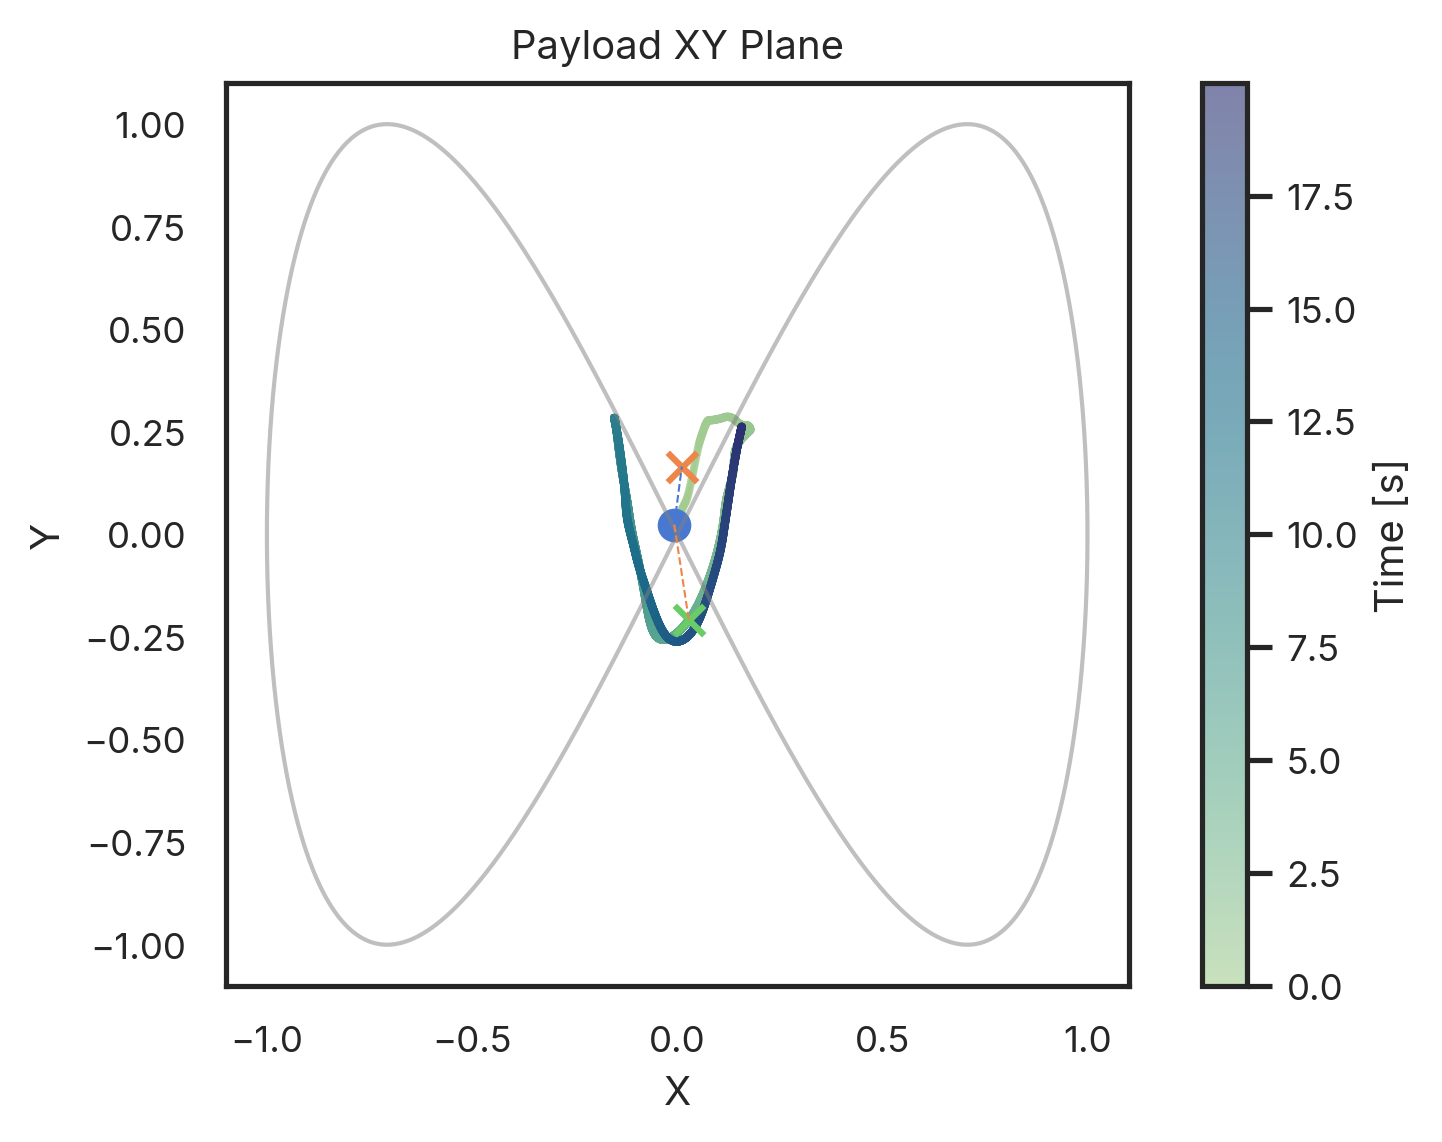

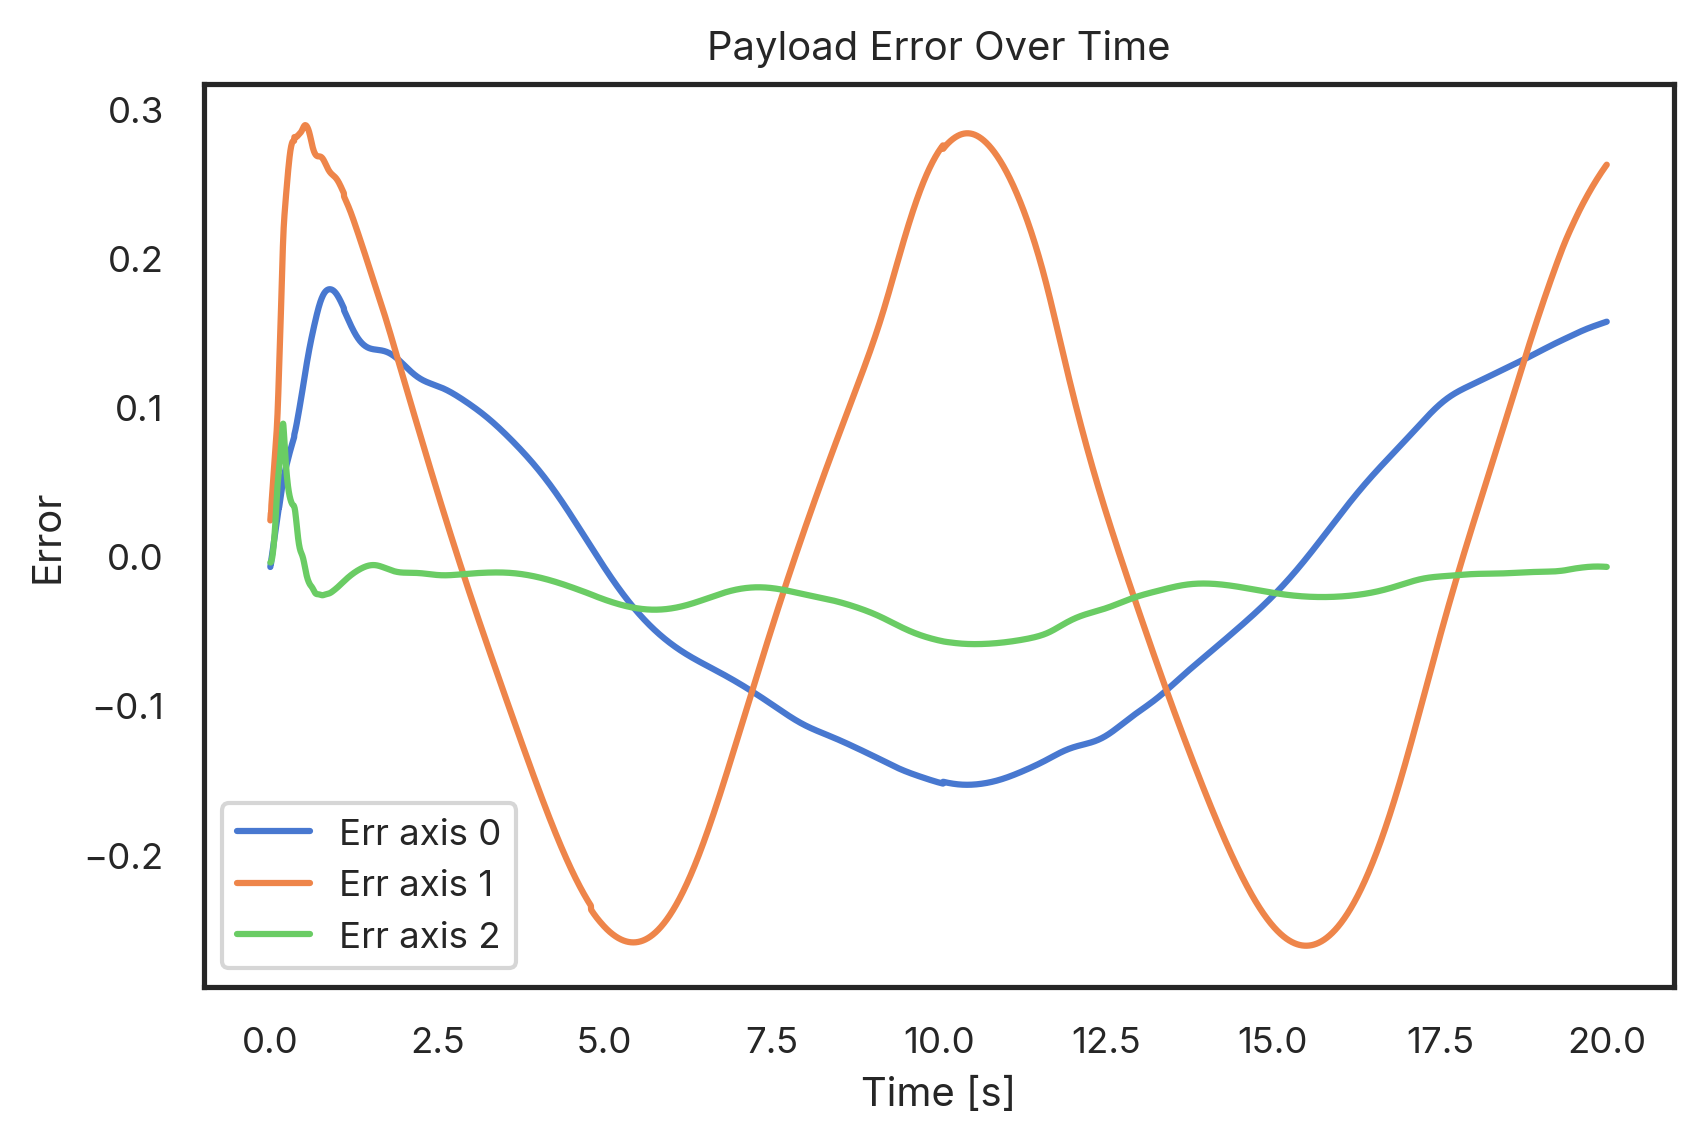

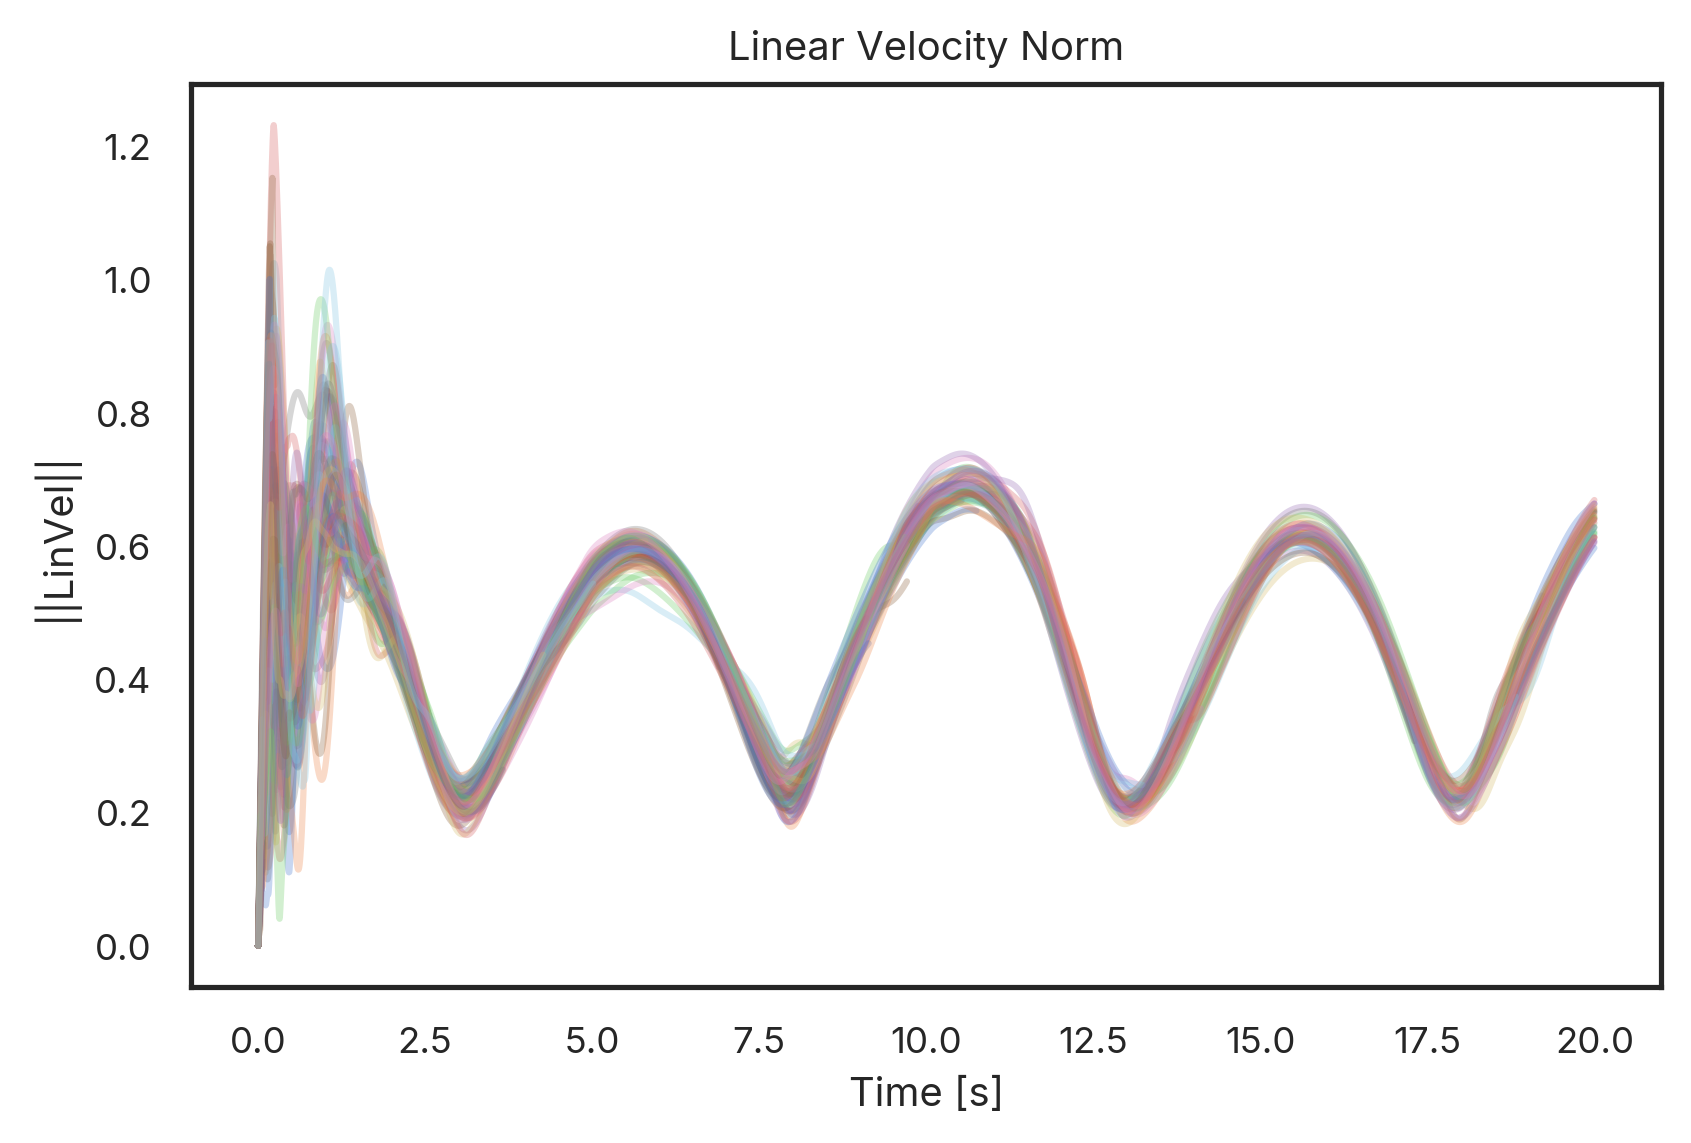

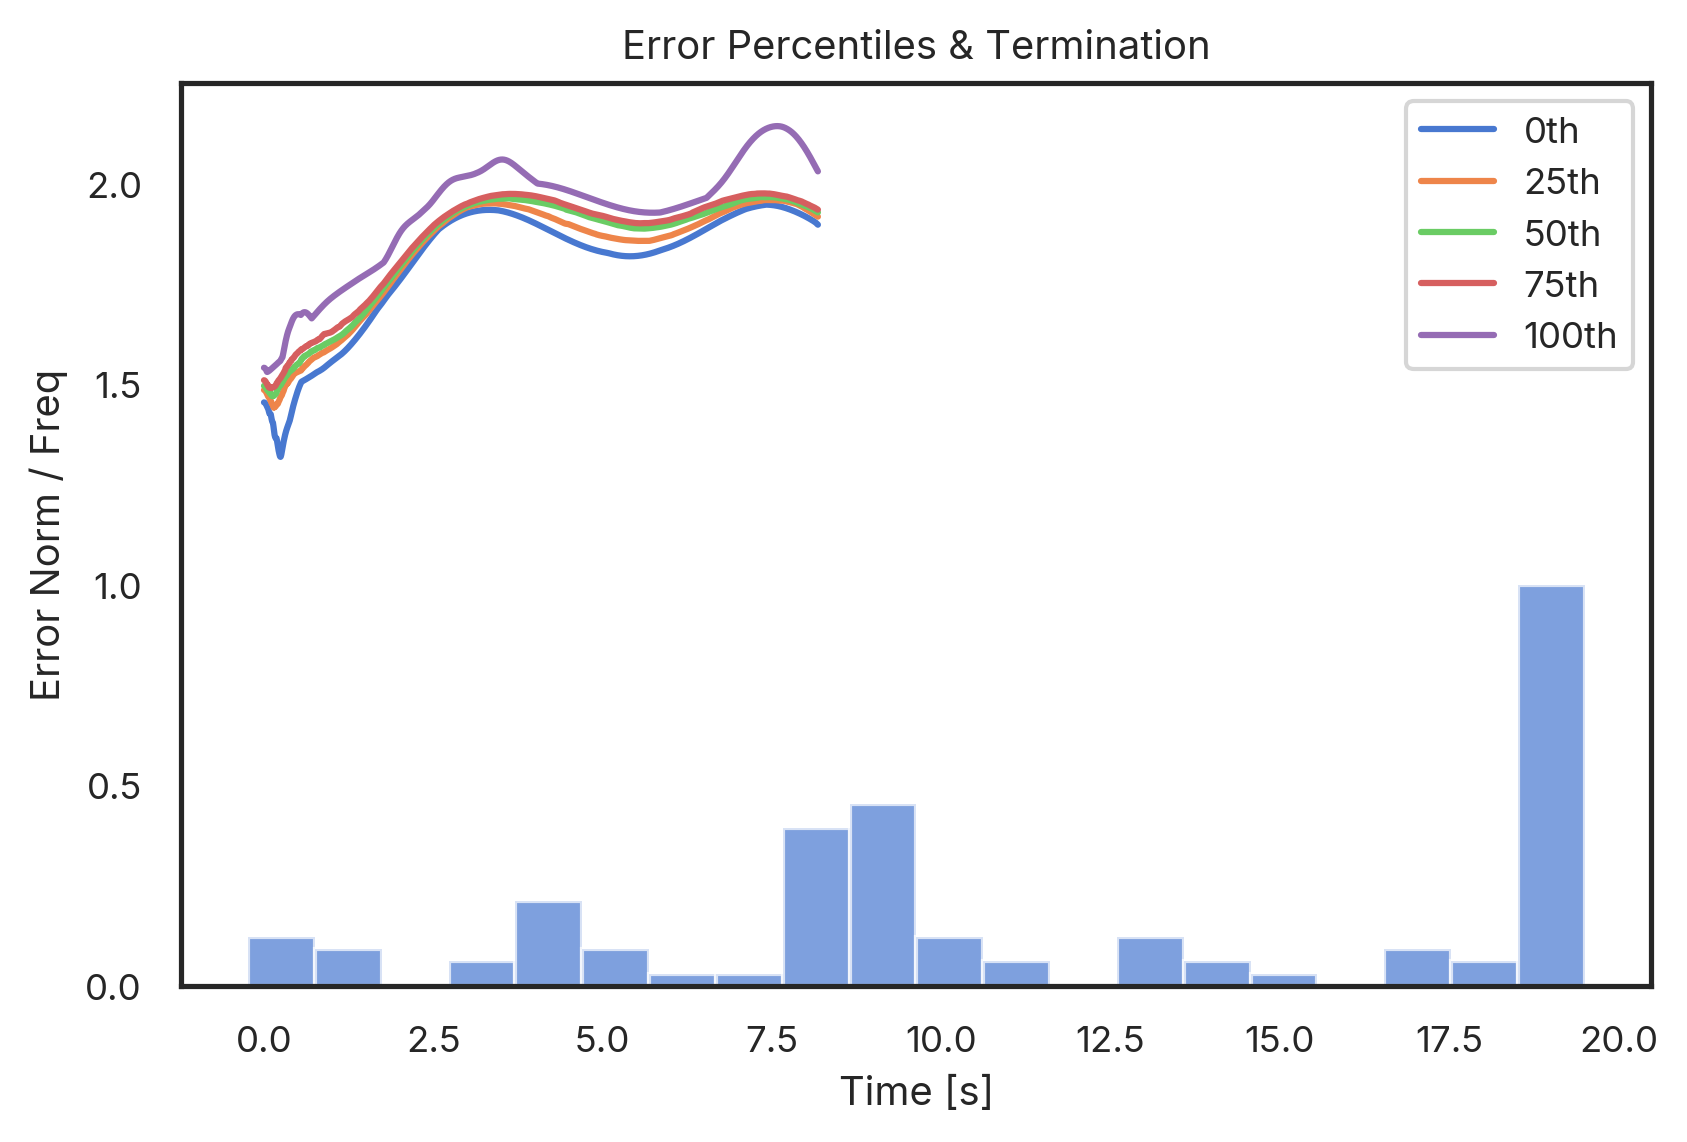

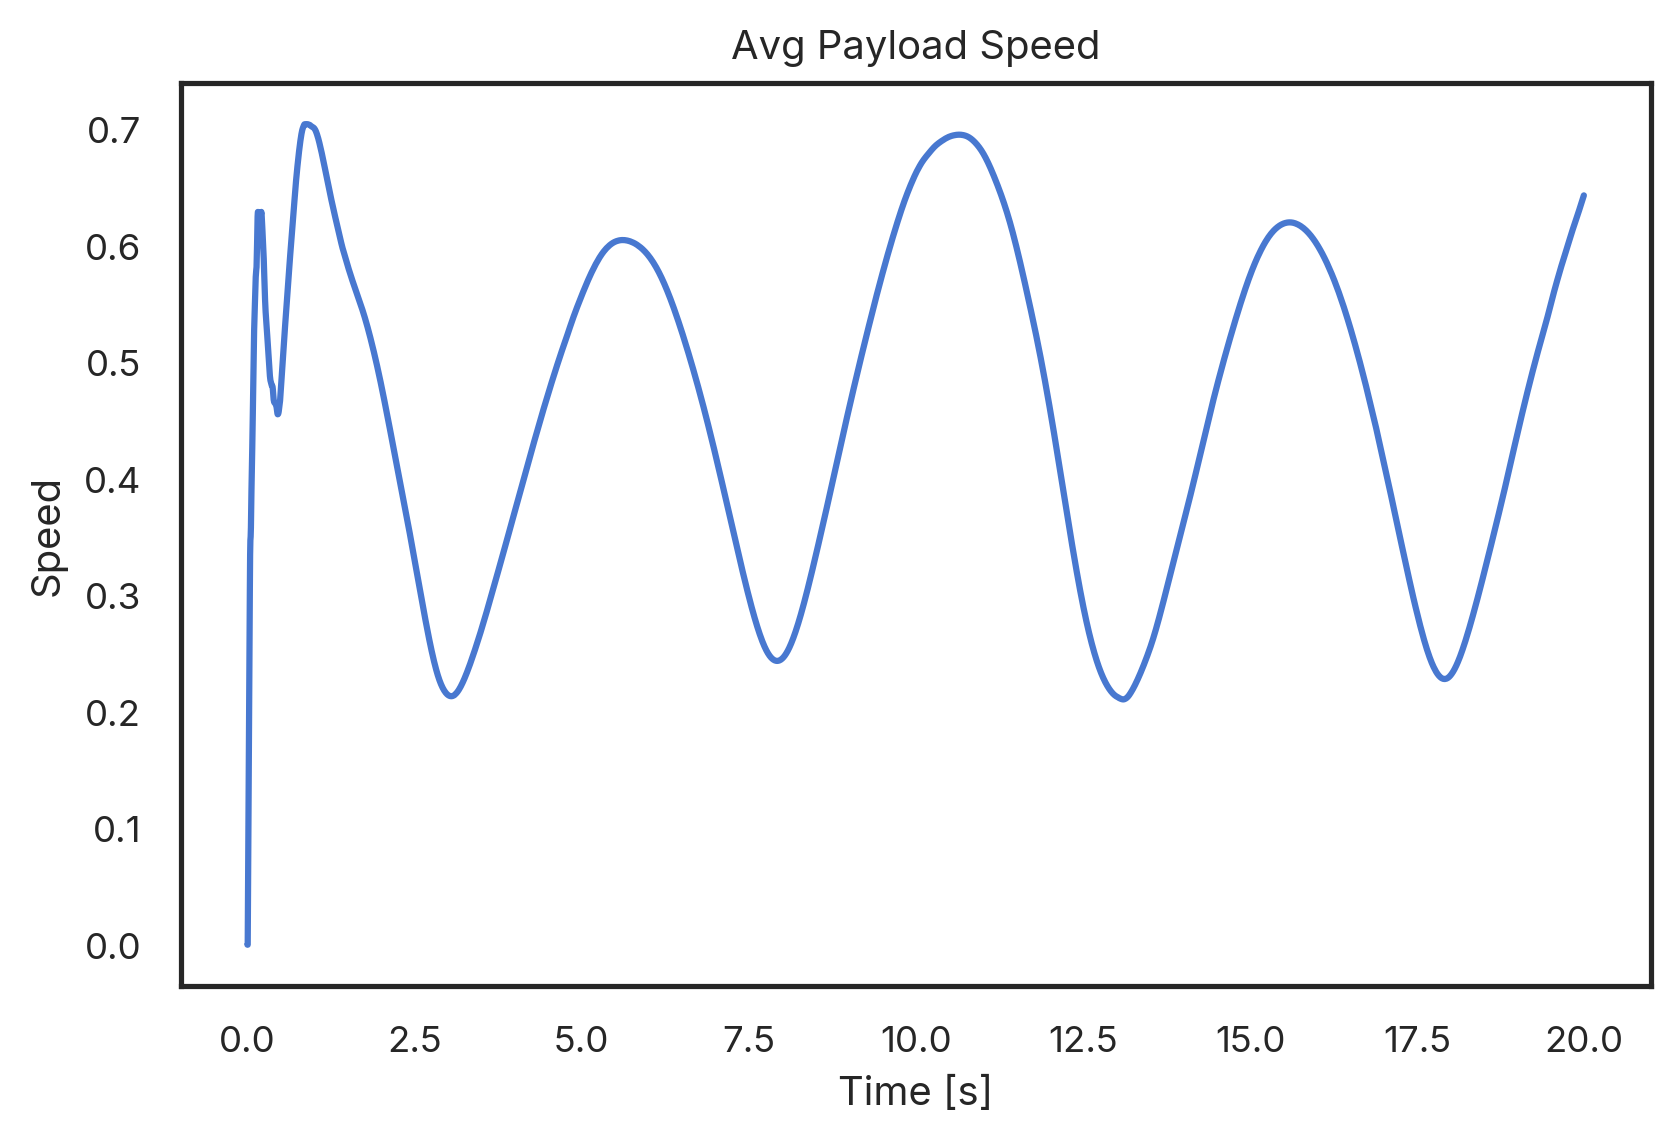

In [6]:
plot_xy_plane(exp)
plot_payload_error_time(exp)
plot_linear_velocity_norm(exp)
plot_error_percentiles(exp)
plot_avg_payload_speed(exp)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../experiments_data/1_quads_recovery_20250619_230918/images/1_quads_recovery_first_frame.png'

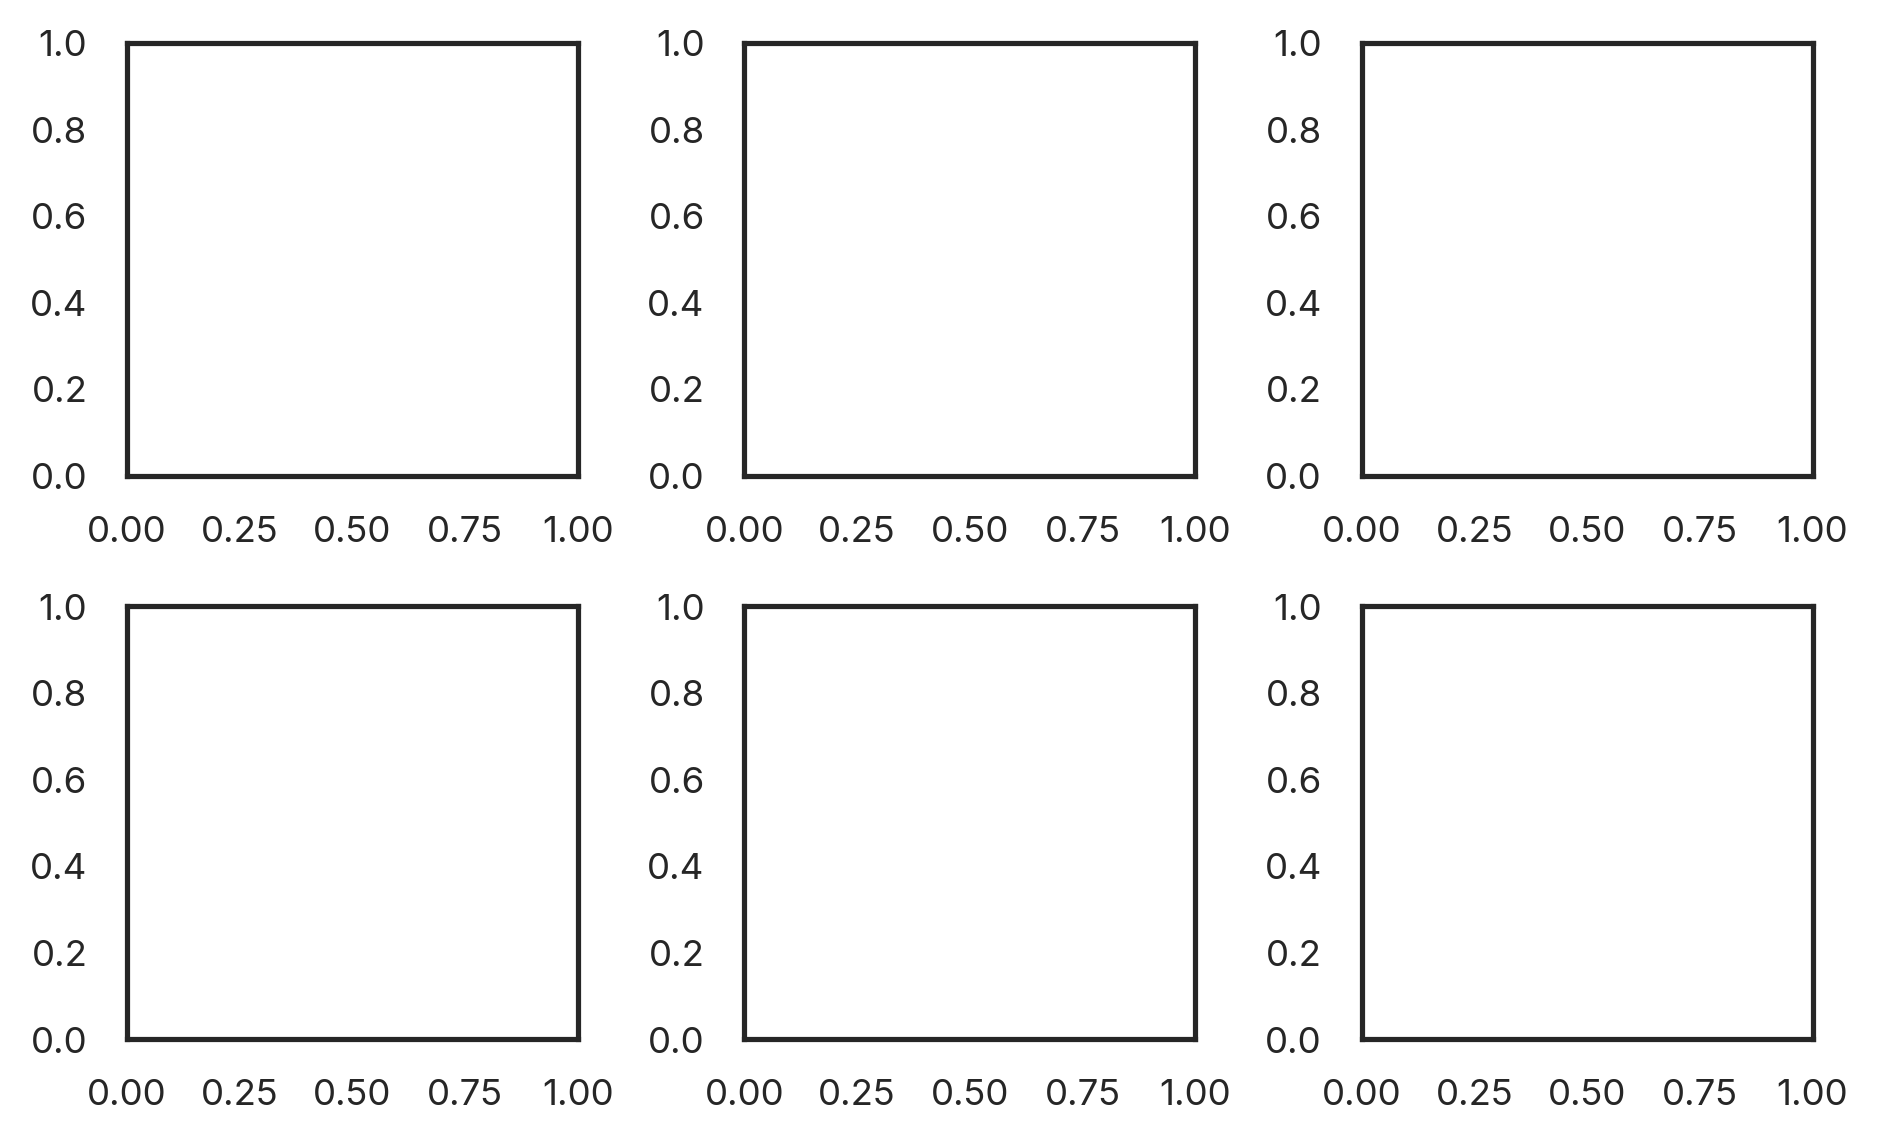

In [7]:
# Plot initial conditions
experiments_data = [
    '1_quads_recovery_20250619_230918',
    '2_quads_recovery_20250619_231158',
    '3_quads_recovery_20250619_231510']

image_paths = [
    f'../experiments_data/{exp_name}/images/{exp_name[0]}_quads_recovery_first_frame.png'
    for exp_name in experiments_data
]

fig, axs = plt.subplots(2, len(image_paths), figsize=(textwidth, textwidth * 0.618))
fig.tight_layout()

# top row: experiment first frames
for ax, img_path, exp_name in zip(axs[0], image_paths, experiments_data):
    num_quads = exp_name[0]
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'N={num_quads}')

# bottom row: placeholder
placeholder_img = plt.imread('../placeholder_initial.png')
for ax in axs[1]:
    ax.imshow(placeholder_img)
    ax.axis('off')

plt.savefig('plots/initial_conditions.png', bbox_inches='tight', dpi=300)